# REINFORCEMENT LEARNING

---
# Introduction

The optimal execution problem using the price impact model of Bertsimas & Lo (1998) is a model where the purchase price P(t) at time t, t = 0, 1, 2..., follows the dynamics:

P(t) = P(t-1) + ϵ(t) + Theta * S(t)

where:

- ϵ(t)’s are i.i.d. random variables, with E[ϵ(t) | S(t),  P(t-1)] = 0
- Theta > 0 is a known constant
- S(t) is the purchase amount at time t

Note that in this model, the price impact is permanent and linear and the parameter Theta is assumed known.

In general, there are various forms of price impact models, including:
1. Linear transient price impact,
2. Linear permanent price impact,
3. Quadratic temporary price impact.

This project is thus to use reinforcement learning to get the optimal order execution strategy under various price impact models. Note that by learning, we assume that the parameters in the models are unknown.

One therefore need to optimize the order execution while learning the model parameters.

**Method:** The easiest way is to generate synthetic price movements, assume these three forms of price impact with unknown model parameters, and use the Q-learning algorithm to find the optimal execution strategy for each of these models. We will be using the sample data from the LOBSTER dataset, available at:
https://lobsterdata.com/info/DataSamples.php.

---
# Import the environment

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures

---
# Learning Model Parameters

##### Variables

In [2]:
steps = 500
n_shares = 100000

##### Shares

In [3]:
share = np.random.multinomial(n_shares, np.ones(steps)/steps, size=1)[0]
share

array([193, 195, 210, 227, 214, 198, 197, 194, 192, 192, 194, 218, 188,
       170, 201, 180, 195, 196, 179, 208, 203, 187, 191, 204, 227, 209,
       192, 197, 203, 208, 217, 193, 165, 173, 206, 211, 225, 204, 197,
       201, 206, 225, 206, 210, 192, 173, 202, 222, 202, 221, 173, 214,
       184, 186, 206, 202, 174, 183, 199, 216, 197, 214, 199, 185, 179,
       219, 187, 212, 191, 198, 228, 182, 177, 184, 219, 220, 171, 194,
       200, 186, 188, 172, 181, 187, 205, 219, 185, 208, 185, 189, 206,
       186, 189, 171, 189, 214, 187, 197, 228, 185, 220, 195, 205, 209,
       185, 186, 192, 208, 203, 202, 179, 211, 224, 205, 214, 194, 220,
       218, 205, 221, 196, 194, 209, 220, 225, 220, 202, 208, 208, 196,
       177, 183, 195, 198, 201, 233, 193, 198, 175, 194, 187, 194, 183,
       188, 189, 200, 191, 204, 194, 177, 189, 189, 212, 189, 244, 195,
       221, 190, 189, 225, 203, 206, 182, 199, 215, 200, 214, 222, 210,
       194, 183, 207, 203, 217, 186, 196, 195, 184, 206, 212, 20

##### Noise

In [4]:
noise = list(np.random.normal(0, 1, size = steps)) 

##### Data

In [5]:
#Import the message dataset to learn the model parameters
message = pd.read_csv('LOBSTER_SampleFile_AAPL_2012-06-21_1/AAPL_2012-06-21_34200000_57600000_message_1.csv')
message.columns = ['time', 'event_type', 'order_id', 'size', 'price', 'direction']
message.head()

,time,event_type,order_id,size,price,direction
0,34200.025552,1,16120456,18,5859100,-1
1,34200.201743,3,16120456,18,5859100,-1
2,34200.201781,3,16120480,18,5859200,-1
3,34200.205573,1,16167159,18,5853600,1
4,34200.271740,1,3647217,20,5857300,1


##### Prices

In [6]:
prices = (message['price']/10000).to_list()
prices = prices[0: steps+1]

---
# Linear Permanent Price Impact

##### Model

    P(t) = P(t - 1) + Noise + Theta * S(t)

##### Function

In [7]:
def linear_permanent_price_impact(price, theta, n_shares):
    # Model the purchase price at time t knowing the one at time t-1 and the number of shares at time t
    noise = np.random.uniform()
    new_price = price + noise + theta * n_shares   #Formula
    return int(new_price)

##### Plot

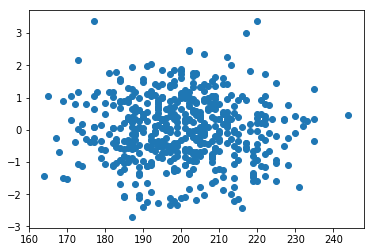

In [8]:
X = share
X = X.reshape(-1,1)
Y = np.diff(prices) - noise
Y = Y.reshape(-1,1)
plt.scatter(X,Y);

##### Conclusion

In [9]:
theta = LinearRegression(fit_intercept=False).fit(X,Y).coef_[0][0]
print('theta = ', theta)

theta =  8.857689508449911e-05


---
# Linear Transient Price Impact

##### Model
    
    P(t) = P(t - 1) + Noise + Theta * S(t) * exp(- alpha * t)

##### Function

In [10]:
def linear_transient_price_impact(price, theta, alpha, t, n_shares):
    # Model the purchase price at time t knowing the one at time t-1 and the number of shares at time t
    noise = np.random.uniform()
    new_price = price + noise + theta * np.exp(-alpha*t) * n_shares   #Formula
    return int(new_price)

##### Plot

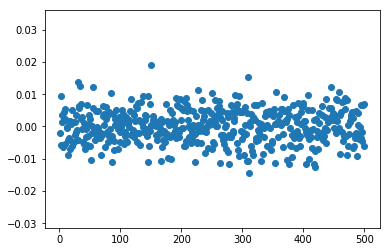

In [11]:
X_2 = np.array(range(1, steps + 1))
Y_2 = (np.diff(prices)-noise)/share
plt.scatter(X_2, Y_2);

##### Conclusion

In [12]:
theta, alpha = curve_fit(lambda t,theta,alpha: theta * np.exp(-alpha*t),  X_2,  Y_2, maxfev=n_shares)[0]
print('theta = ',theta)
print('alpha = ', alpha)

theta =  -42.18176125067094
alpha =  10.01638130323956


---
# Quadratic Temporary Price Impact

##### Model 

    P(t) = P(t - 1) + Noise + a * S(t) + b * S(t)²

##### Function

In [13]:
def quadratic_temporary_price_impact(price, a, b, n_shares):
    # Model the purchase price at time t knowing the one at time t-1 and the number of shares at time t
    noise = np.random.uniform()
    new_price = price + noise + a * n_shares + b * n_shares**2  #Formula
    return int(new_price)

##### Plot

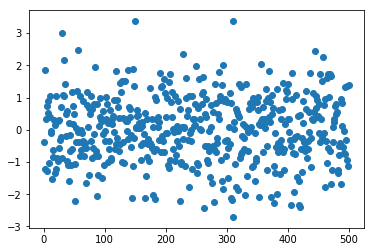

In [14]:
X_3 = np.array(range(1, steps + 1))
Y_3 = (np.diff(prices)-noise)
plt.scatter(X_3, Y_3);

##### Conclusion

In [15]:
model = PolynomialFeatures(degree=2,include_bias = False)
X_3 = model.fit_transform(X)
Y_3 = Y
model_2 = LinearRegression(fit_intercept = False)
model_2.fit(X_3, Y_3)
print('a = ', model_2.coef_[0][1])
print('b = ', model_2.coef_[0][0])

a =  -4.383993619645826e-06
b =  0.0009738143251463515


---
# Input variables

In [16]:
price_range = 20
time = 20
share = 20
eta = 0.5   # Learning rate
gamma = 0.9
iterations = 100000

---
# Useful Functions

### Next State

A state is defined by:

    State = (time, price, number of share)
    
Therefore:

    Next State = (time + 1, New price, New number of share)
    
With:
- New price computed with the previous function
- New number of shares is equal to the old number of shares minus the action that is chosen

In [17]:
def next_state(state, action, new_price):
    # Model the next state after taking an action a and being on a state s
    t = state[0] + 1   #Increase the time by one
    p = new_price   #New price
    s = state[2] - action   #New number of share
    new_state = (t, p, s)
    return new_state

### Reward

The reward is just equal to the opposite of the product of the price and the action that is taken.

In [18]:
def reward(state, action, next_state, new_price):
    # Return the reward earned after taking an action and being on a new state
    rew = - action * next_state[1]
    return rew

---
# Create the states

In [19]:
states = []

for i in range(0, time+1):
    for j in range(0, price_range+1):
        for k in range(0, share+1):
            states.append((i,j,k))

In [20]:
states

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 0, 10),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (0, 1, 12),
 (0, 1, 13),
 (0, 1, 14),
 (0, 1, 15),
 (0, 1, 16),
 (0, 1, 17),
 (0, 1, 18),
 (0, 1, 19),
 (0, 1, 20),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 2, 10),
 (0, 2, 11),
 (0, 2, 12),
 (0, 2, 13),
 (0, 2, 14),
 (0, 2, 15),
 (0, 2, 16),
 (0, 2, 17),
 (0, 2, 18),
 (0, 2, 19),
 (0, 2, 20),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 3, 10),
 (0, 3, 11),
 (0, 3, 12),
 (0, 3, 13),
 (0, 3, 14),
 (0, 3, 15),
 (0, 3, 16),


---
# Q-learning Algorithm

I used the following formula to implement the Q-learning matrix:

    𝑄𝑛𝑒𝑤(𝑠,𝑎) = (1− Ƞ) 𝑄𝑜𝑙𝑑(𝑠,𝑎)+ Ƞ [ 𝑅(𝑠,𝑎,𝑛𝑒𝑤_𝑠𝑡𝑎𝑡𝑒)+ 𝛾 max 𝑄(𝑁(𝑠,𝑎), 𝑎′) ]
    
To implement this code, I used the following algorithm:
1. Initialize Q(s, a) = 0 for every a and s


2. 
    a) Randomly choose an initial state s
    
    b) Randomly choose an admissible action a
    
    c) Compute the new state
    
    d) Update Q(s, a) with the formula
    
    
3. Repeat step 2 for N iterations or until you touch the target (here the target is the maximum time: if the time of the new state is superior than the maximum time, the target is reached).


4. Return the Q matrix

---
# Initialize the Q-learning matrix

In [21]:
Q_learning = dict()

for i in range(0, len(states)):
    s = states[i]
    Q_learning[s] = {}
    for j in range(0, s[2] + 1):
        Q_learning[s][j] = 0

In [22]:
Q_learning

{(0, 0, 0): {0: 0},
 (0, 0, 1): {0: 0, 1: 0},
 (0, 0, 2): {0: 0, 1: 0, 2: 0},
 (0, 0, 3): {0: 0, 1: 0, 2: 0, 3: 0},
 (0, 0, 4): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
 (0, 0, 5): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 (0, 0, 6): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0},
 (0, 0, 7): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
 (0, 0, 8): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0},
 (0, 0, 9): {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 (0, 0, 10): {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0},
 (0, 0, 11): {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0},
 (0, 0, 12): {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0},
 (0, 0, 13): {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0},
 (0, 0, 14): {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,


---
# Implement the Q-learning matrix with the Linear Permanent Price Impact

##### We define the model variables according to the previous analysis

In [23]:
theta = 0.1

##### Q matrix

In [24]:
Q_learning_LPP = Q_learning.copy()

In [25]:
for i in range(0, iterations):
    # Choose a random state
    s = random.choice(states)
    # Choose a random action
    a = np.random.choice(s[2] + 1)
    # Compute the new price
    new_p = linear_permanent_price_impact(s[1], theta, s[2]-a)
    # Compute the new state
    new_s = next_state(s, a, new_p)
    # If the new state touch the target, we stop
    if(new_s[0] > time):
        continue
    # Compute the new value of Q if the new state is in our list of states
    if (new_s in states) == True:
        Q_learning_LPP[s][a] = (1-eta) * Q_learning_LPP[s][a] + eta * ( reward(s,a,new_s, new_p) + 
                                                                       gamma * max(Q_learning_LPP[new_s].values()) )

##### Results

In [26]:
Q_learning_LPP

{(0, 0, 0): {0: 0.0},
 (0, 0, 1): {0: 0.0, 1: 0.0},
 (0, 0, 2): {0: 0.0, 1: 0.0, 2: 0.0},
 (0, 0, 3): {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 (0, 0, 4): {0: 0, 1: 0, 2: 0.0, 3: -2.25, 4: 0.0},
 (0, 0, 5): {0: 0, 1: 0.0, 2: -1.0, 3: 0.0, 4: 0.0, 5: 0.0},
 (0, 0, 6): {0: 0, 1: 0, 2: -1.5, 3: 0.0, 4: 0, 5: 0.0, 6: 0.0},
 (0, 0, 7): {0: 0.0,
  1: -0.625,
  2: 0,
  3: -2.25,
  4: -0.5,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 (0, 0, 8): {0: 0.0,
  1: 0,
  2: 0,
  3: -2.0625,
  4: -1.0,
  5: 0,
  6: 0.0,
  7: 0.0,
  8: 0},
 (0, 0, 9): {0: 0.0,
  1: 0.0,
  2: 0,
  3: -0.75,
  4: -3.0,
  5: 0,
  6: 0.0,
  7: 0.0,
  8: 0,
  9: 0},
 (0, 0, 10): {0: 0.0,
  1: -0.5,
  2: -1.0,
  3: -1.5,
  4: -2.0,
  5: -3.75,
  6: 0,
  7: 0.0,
  8: 0,
  9: 0,
  10: 0.0},
 (0, 0, 11): {0: 0.0,
  1: -0.75,
  2: -1.0,
  3: -1.5,
  4: 0.0,
  5: 0,
  6: 0,
  7: 0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0},
 (0, 0, 12): {0: 0.0,
  1: -0.5,
  2: -1.0,
  3: -1.5,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 

---
# Implement the Q-learning matrix with the Linear Transient Price Impact

##### We define the model variables according to the previous analysis

In [27]:
theta = 0.02
alpha = 1.31

##### Q matrix

In [28]:
Q_learning_LTP = Q_learning.copy()

In [29]:
for i in range(0, iterations):
    # Choose a random state
    s = random.choice(states)
    # Choose a random action
    a = np.random.choice(s[2] + 1)
    # Compute the new price
    new_p = linear_transient_price_impact(s[1], theta, alpha, s[0], s[2]-a)
    # Compute the new state
    new_s = next_state(s, a, new_p)
    # If the new state touch the target, we stop
    if(new_s[0] > time):
        continue
    # Compute the new value of Q if the new state is in our list of states
    if (new_s in states) == True:
        Q_learning_LTP[s][a] = (1-eta) * Q_learning_LTP[s][a] + eta * ( reward(s,a,new_s, new_p) + 
                                                                       gamma * max(Q_learning_LTP[new_s].values()) )

##### Results

In [30]:
Q_learning_LTP

{(0, 0, 0): {0: 0.0},
 (0, 0, 1): {0: 0.0, 1: 0.0},
 (0, 0, 2): {0: 0.0, 1: 0.0, 2: 0.0},
 (0, 0, 3): {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 (0, 0, 4): {0: 0.0, 1: 0, 2: 0.0, 3: -0.5625, 4: 0.0},
 (0, 0, 5): {0: 0.0, 1: 0.0, 2: -0.5, 3: 0.0, 4: 0.0, 5: 0.0},
 (0, 0, 6): {0: 0, 1: 0.0, 2: -0.75, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0},
 (0, 0, 7): {0: 0.0,
  1: -0.3125,
  2: 0,
  3: -2.25,
  4: -0.5,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 (0, 0, 8): {0: 0.0,
  1: 0.0,
  2: 0,
  3: -2.0625,
  4: -1.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0},
 (0, 0, 9): {0: 0.0,
  1: -0.5,
  2: 0,
  3: -0.75,
  4: -1.5,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0,
  9: 0.0},
 (0, 0, 10): {0: 0.0,
  1: -0.25,
  2: -1.0,
  3: -0.75,
  4: -0.5,
  5: -0.9375,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: -4.5,
  10: 0.0},
 (0, 0, 11): {0: 0.0,
  1: -0.75,
  2: -1.25,
  3: -1.5,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0},
 (0, 0, 12): {0: 0.0,
  1: -0.25,
  2: -0.125,
  3: -0.75,
  4: 0,
  5: 0,
  6: 0.0,
  7

---
# Implement the Q-learning matrix with the Quadratic Temporary Price Impact

##### We define the model variables according to the previous analysis

In [31]:
a = 3.07 * 10**(-5)
b = -0.0065

##### Q matrix

In [32]:
Q_learning_QTP = Q_learning.copy()

In [33]:
for i in range(0, iterations):
    # Choose a random state
    s = random.choice(states)
    # Choose a random action
    a = np.random.choice(s[2] + 1)
    # Compute the new price
    new_p = quadratic_temporary_price_impact(s[1], a, b, s[2]-a)
    # Compute the new state
    new_s = next_state(s, a, new_p)
    # If the new state touch the target, we stop
    if(new_s[0] > time):
        continue
    # Compute the new value of Q if the new state is in our list of states
    if (new_s in states) == True:
        Q_learning_QTP[s][a] = (1-eta) * Q_learning_QTP[s][a] + eta * ( reward(s,a,new_s, new_p) + 
                                                                       gamma * max(Q_learning_QTP[new_s].values()) )

##### Results

In [34]:
Q_learning_QTP

{(0, 0, 0): {0: 0.0},
 (0, 0, 1): {0: 0.0, 1: 0.0},
 (0, 0, 2): {0: 0.0, 1: -0.96875, 2: 0.0},
 (0, 0, 3): {0: 0.0, 1: -1.75, 2: -3.0, 3: 0.0},
 (0, 0, 4): {0: 0.0, 1: -2.25, 2: -6.0, 3: -4.78125, 4: 0.0},
 (0, 0, 5): {0: 0.0, 1: -3.5, 2: -10.5625, 3: -13.5, 4: -8.0, 5: 0.0},
 (0, 0, 6): {0: 0,
  1: -4.375,
  2: -8.375,
  3: -13.5,
  4: -16.0,
  5: -18.75,
  6: 0.0},
 (0, 0, 7): {0: 0.0,
  1: -0.3125,
  2: -10.0,
  3: -27.5625,
  4: -0.5,
  5: -25.0,
  6: -18.0,
  7: 0.0},
 (0, 0, 8): {0: 0.0,
  1: -3.5,
  2: -12.0,
  3: -23.53125,
  4: -1.0,
  5: -37.5,
  6: -54.0,
  7: 0.0,
  8: 0.0},
 (0, 0, 9): {0: 0.0,
  1: -5.625,
  2: -14.0,
  3: -25.875,
  4: -1.5,
  5: -75.0,
  6: -81.0,
  7: -85.75,
  8: 0,
  9: 0.0},
 (0, 0, 10): {0: 0.0,
  1: -0.25,
  2: -28.9375,
  3: -0.75,
  4: -0.5,
  5: -0.9375,
  6: 0.0,
  7: 0.0,
  8: -64.0,
  9: -4.5,
  10: 0.0},
 (0, 0, 11): {0: 0.0,
  1: -7.96875,
  2: -1.25,
  3: -1.5,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0,
  8: 0.0,
  9: -81.0,
  10: -75.0,
  11: